In [1]:
using Knet, Plots, Statistics, LinearAlgebra, Random

In [2]:
λ = 0.001 # regularization
η = 0.1 # learning rate

n=12 # length of input bit array
xdim = n
h1=h2=h3=2*n # hidden layer sizes
ydim = 1 # output is the probability for even parity
nbatch = 100 # number of bit strings presented at each iteration
ntest = div(2^n,8) # keep 1/8-th as test set
niter = 10^5 # number of training iterations

100000

In [3]:
# NN parameters
w1 = Param(randn(h1,xdim))
b1 = Param(randn(h1))
w2 = Param(randn(h2,h1))
b2 = Param(randn(h2))
w3 = Param(randn(h3,h2))
b3 = Param(randn(h3))
w4 = Param(randn(1,h3))
b4 = Param(randn(1))
w = (w1,w2,w3,w4)
b = (b1,b2,b3,b4)
length(w)

4

In [4]:
# returns binary digits of an integer
binar(nbits,x) = digits(x, base=2, pad=nbits) |> reverse

binar (generic function with 1 method)

In [5]:
# prediction and loss functions
σ(x) = relu(x)
layer(w,b,x) = σ.(w*x .+ b)
pred(w,b,x)=sigm.(w[4]*layer(w[3],b[3],layer(w[2],b[2],layer(w[1],b[1],x))).+b[4])
loss(w,b,x,y) = mean(abs2,pred(w,b,x)-y) + (λ/2)mean(sum.(abs,w))

loss (generic function with 1 method)

In [6]:
# split integers in (1,..,2ⁿ-1) to training and test sets
testidx = randperm(2^n-1)[1:ntest]
trainidx = setdiff(1:2^n-1,testidx) # samples not in the test set
ntrain = length(trainidx)

xtst = zeros(Int64,n,ntest)
for i=1:ntest
    xtst[:,i] = binar(n,testidx[i])
end
ytst = sum(xtst,dims=1).%2

xtrn = zeros(Int64,n,ntrain)
for i=1:ntrain
    xtrn[:,i] = binar(n,trainidx[i])
end
ytrn = sum(xtrn,dims=1).%2

size(xtrn),size(pred(w,b,xtrn))

((12, 3583), (1, 3583))

In [7]:
# Generate a batch: integer array of size (n x nbatch)
function genbatch(nbit,nbat)
    batchidx = shuffle(trainidx)[1:nbat]
    out = zeros(Int64,nbit,nbat)
    for i=1:nbat
        out[:,i] = binar(nbit,batchidx[i])
    end
    return out
end

genbatch (generic function with 1 method)

┣████████████████████┫ [100.00%, 100000/100000, 00:47/00:47, 2135.29i/s] 


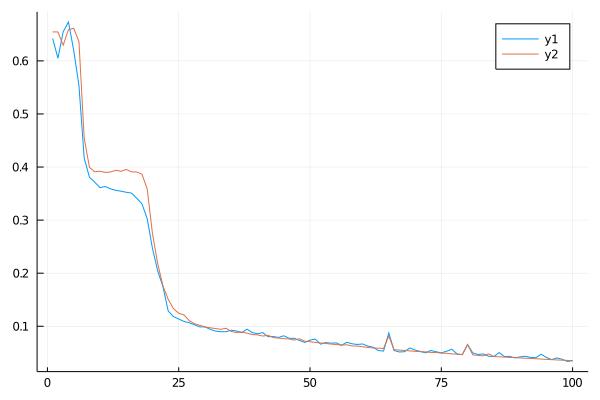

In [8]:
losstrn = []
losstst = []
for k in progress(1:niter)
    xin = genbatch(n,nbatch)
    yin = sum(xin,dims=1).%2
    dl = @diff loss(w,b,xin,yin)
    for i=1:length(w)
        w[i] .-= η*grad(dl,w[i])
        b[i] .-= η*grad(dl,b[i])
    end
    if (k%1000==1)
        xin = genbatch(n,ntest) # training set samples with size equal to test set
        yin = sum(xin,dims=1).%2 
        push!(losstrn,loss(w,b,xin,yin)) # record loss over 1000 samples
        push!(losstst,loss(w,b,xtst,ytst))
    end
end
plot(losstrn)
plot!(losstst)

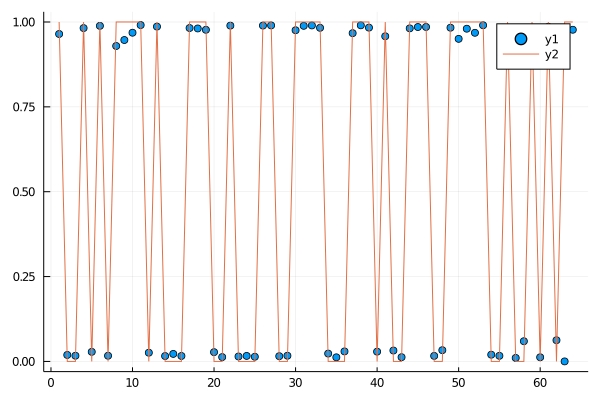

In [9]:
np=min(ntest,64)
scatter(pred(w,b,xtst)[1:np]
#    ,xlim=(0,np)
)
plot!(ytst[1:np])

In [10]:
# accuracy
function acc(x,y)
    cnt = 0
    tot = length(x[1,:])
    for i=1:tot-1
        chk = (pred(w,b,x[:,i])[1] - y[i][1])^2
        if (chk < 0.5)
            cnt += 1
        end
    end
    return 1.0*cnt/tot
end

acc (generic function with 1 method)

In [11]:
acc(xtrn,ytrn),acc(xtst,ytst)

(0.9935807982137873, 0.994140625)

In [12]:
# distribution of weights
histogram(reshape(w1,:,1)[:,1],normalize=:pdf)

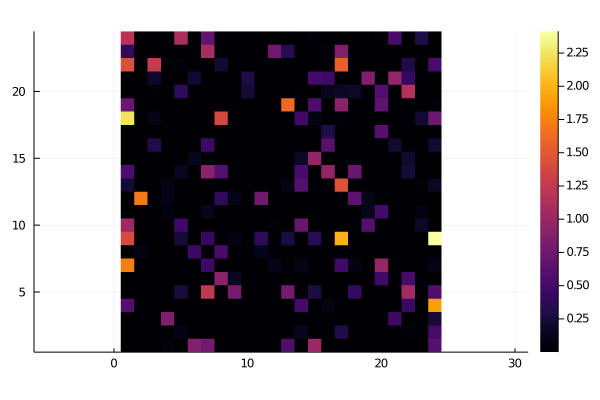

In [13]:
heatmap(abs.(value(w2)),aspect_ratio=1)

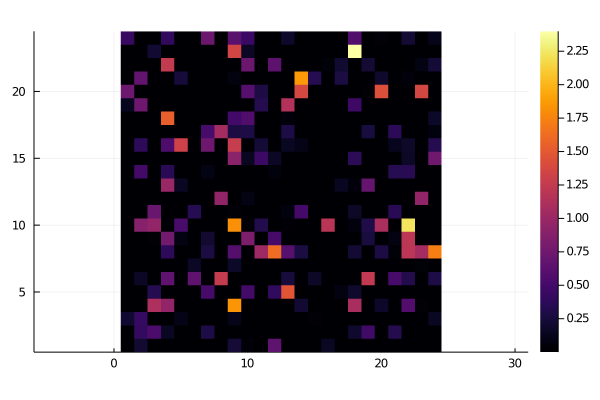

In [14]:
heatmap(abs.(value(w3)),aspect_ratio=1)

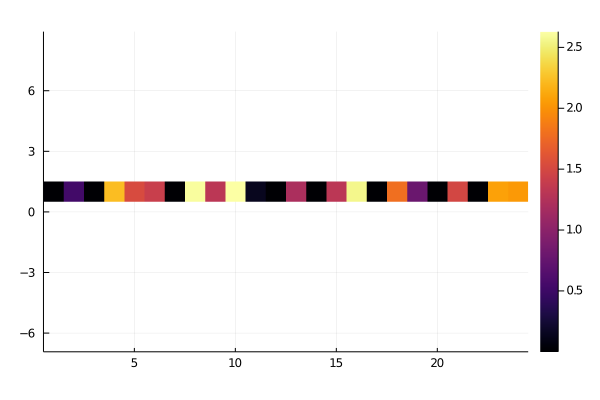

In [15]:
heatmap(abs.(value(w4)),aspect_ratio=1)